<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT20/blob/leoenge/Lab-6/leoenge_lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 6: Differential Equations**
**Leo Enge**

# **Abstract**

In this report we implement the implicit Euler method for solving scalar differential equations aswell as systems of differential equations. We then test the accuracy and stability of the methods for a quite simple model. For the tested models both the methods proved to be both accurate and stable.

#**About the code**

A short statement on who is the author of the file, and if the code is distributed under a certain license. 

In [0]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Leo Enge (leoe@kth.se)
# Discussed problems with Christoffer Ejemyr

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [0]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import newton

# **Methods**

## Implicit Euler for scalar D.E.
We wish to solve the differential equation
\begin{align}
&\frac{du}{dt} = f(u,t) \\ 
&u(0) = u_0
\end{align}
using a numerical method. We choose to use the implicit Euler, implementing it much the same way as algorithm 13.2 in the lecture notes.

In [0]:
def scalar_implicit_euler(func, u0, T):
  timestep = 1e-3
  no_of_steps = int(np.around(T/timestep) + 1)
  t_vector, timestep = np.linspace(0, T, num=no_of_steps, retstep=True)
  u = np.zeros(no_of_steps)
  u[0] = u0
  for i,t in enumerate(t_vector[1:]):
    u[i+1] = newton(lambda x: x - u[i] - timestep*func(x,t), u[i])
  return t_vector, u

### Test scalar solver
We are supposed to varify the accuracy and stability of the method for some system. We choose to test it for the system given by
\begin{equation}
\frac{du}{dt} = f(u,t) = \lambda \cdot u(t)
\end{equation}
where we set $\lambda = -1$. This system has the exact solution 
\begin{equation}
u_{exact}(t) = u_0 \cdot \text{e}^{\lambda t}
\end{equation}
For some different values for $u_0$ we calculate the approximate solution $u_{approx}$ and plot it toghether with the exact solution for each value of $u_0$.

We also calculate the error $u_{approx} - u_{exact}$ and plot it.



In [0]:
def get_func(c):
  def f(u, t):
    return c*u
  return f

In [0]:
def test_scalar():
  u0s = np.array([-10, -1, -0.1, 0, 0.1, 1, 10])
  T = 10
  some_constant_lambda = -1
  f = get_func(some_constant_lambda)
  fig,a = plt.subplots(2,1)

  for u0 in u0s:
    t_vector, u_approx = scalar_implicit_euler(f, u0, T)
    u_exact = u0*np.exp(some_constant_lambda*t_vector)
    rel_error = (u_approx-u_exact)
    if not u0==0:
      rel_error = rel_error/u0

    a[0].set_title("Plot of approximate solution and exact solution")
    a[0].plot(t_vector, u_exact, color='blue')
    a[0].plot(t_vector, u_approx, color='red')

    a[1].set_title('Error of approximate solution')
    a[1].plot(t_vector, rel_error)


## Implicit Euler for system of D.E.
We now instead have a system of differential equations
\begin{align}
&\frac{du}{dt} = \left( \frac{du_1}{dt}, \dots \frac{du_n}{dt} \right) \\
&u(0) = u_0
\end{align}
We find an approximate solution of this system by the same stepping alorithm as before, with the difference that the Newton method now takes a vector function.

In [0]:
def system_implicit_euler(func, u0, T):
  n = u0.size
  timestep = 1e-3
  no_of_steps = int(np.around(T/timestep)) + 1
  t_vector,timestep = np.linspace(0, T, num=no_of_steps, retstep=True)
  u = np.zeros((n,t_vector.size))
  u[:,0] = u0
  for i,t in enumerate(t_vector[1:]):
    u[:,i+1] = newton(lambda x: x - u[:, i] - timestep*func(x, t), u[:,i])
  return u, t_vector

### Test system solver
As before we should test the system solver for some model. We choose to test the solver for the system 
\begin{equation}
\frac{du}{dt} = Au
\end{equation}
with $A = XDX^{-1}$, where
\begin{equation}
D = \begin{bmatrix}
-1 & 0 & 0\\
0 & -2 & 0 \\
0 & 0 & -3
\end{bmatrix}
\end{equation}
and
\begin{equation}
X = \begin{bmatrix}
1/\sqrt{2} & 0 & -1/\sqrt{2}\\
1/\sqrt{2} & 0 & 1/\sqrt{2} \\
0 & 1 & 0
\end{bmatrix}
\end{equation}
which is an orthogonal matrix. Hence we get the exact solution
\begin{equation}
u_{exact}(t) = X \text{e}^{Dt} X^{-1}u_0 = X \begin{bmatrix}
\text{e}^{-1t} & 0 & 0\\
0 & \text{e}^{-2t} & 0 \\
0 & 0 & \text{e}^{-3t}
\end{bmatrix} X^{-1}u_0
\end{equation}.
We then calculate the error $e(t) = u_{approx}(t) - u_{exact}(t)$. For each $t$ this will be a vector of length $3$, so we take the norm of this vector and plot it against the time. We do this for a set of different random initial value vectors $u_0$.

In [0]:
def exact_solution(X,D,u0,t_vector):
  u = np.zeros((u0.size, t_vector.size))
  d = np.diag(D)
  for i,t in enumerate(t_vector):
    u[:,i] = X.dot(np.diag(np.exp(t*d))).dot(np.linalg.inv(X)).dot(u0)
  return u

In [0]:
def test_system():
  D = np.diag(np.array([-1,-2,-3]))
  X = np.array([[1/np.sqrt(2), 0, -1/np.sqrt(2)],[1/np.sqrt(2), 0, 1/np.sqrt(2)],[0, 1, 0]])
  A = X.dot(D).dot(np.linalg.inv(X))
  T = 10
  fig,a = plt.subplots(2,1)

  for _ in range(5):
    u0 = 10 * (np.random.rand(D.shape[0])-0.5)
    u_approx, t_vector = system_implicit_euler(lambda x,t: A.dot(x), u0, T)
    u_exact = exact_solution(X, D, u0, t_vector)
    error = np.zeros(t_vector.size)
    u_approx_norm = np.zeros(t_vector.size)
    error = np.linalg.norm(u_approx-u_exact, axis=0)
    for i in range(t_vector.size):
      
      u_approx_norm[i] = np.linalg.norm(u_approx[:,i])

    a[0].set_title("Plot of the norm of the approximate solution")
    a[0].plot(t_vector, u_approx_norm, color='blue')

    a[1].set_title("Plot of the error u_approx-u_norm")
    a[1].plot(t_vector,error)

# **Results**

## Test of scalar solver

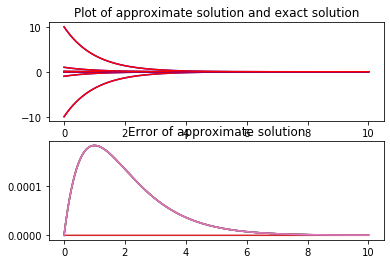

In [0]:
test_scalar()

##Test of system solver

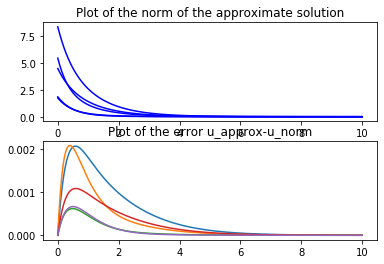

In [0]:
test_system()

# **Discussion**

## Scalar solver
We see that the approximate solution follow the exact solution so well that we cannot even see the plot of the exact solution. Looking at the plot of the error we see that this is indees very small all through. We have tested for both a small and a large positive and negative initial value and in all cases the approximate solution follows the exact solution and approaches the stationary point. So we conclude that the implicit euler implemented is stable for the given differential equation.

## System solver
In the same way as for the scalar solver, we see that the error apporaches zero and that the norm of the approximate solution goes to zero for all the initial values, so we conclude that the method is accurate and stable for this system of differential equations.